In [1]:
# import libraries
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import time
import math

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm

import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn import preprocessing, metrics

from sklearn.model_selection import GridSearchCV

import subprocess
import sys
# for uninstalled packages, use:
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
## Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified by @Vopani

# to support timestamp type, categorical type and to add option to use float16
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# specify path to raw data
path_data = 'C:/Users/nwolp/Desktop/M5/'

In [4]:
# Function for reading and transforming data

def read_and_transform(start_day=1, dep_id='all'):
    
    dtypes_calendar={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
             "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
            "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
    dtypes_sell_prices = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }
    
    # transform categorical variables into int16 format since it saves memory

    sell_prices = pd.read_csv(path_data + 'sell_prices.csv', dtype = dtypes_sell_prices)
    
    for col, col_dtype in dtypes_sell_prices.items():
        if col_dtype == "category":
            sell_prices[col] = sell_prices[col].cat.codes.astype("int16")
            sell_prices[col] -= sell_prices[col].min()

    calendar = pd.read_csv(path_data + 'calendar.csv', dtype = dtypes_calendar)

    calendar["date"] = pd.to_datetime(calendar["date"])
    for col, col_dtype in dtypes_calendar.items():
        if col_dtype == "category":
            calendar[col] = calendar[col].cat.codes.astype("int16")
            calendar[col] -= calendar[col].min()

    # start from given day

    numcols = [f"d_{day}" for day in range(start_day,1914)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    sales_train_val = pd.read_csv(path_data + 'sales_train_validation.csv', usecols = catcols + numcols, dtype = dtype)
    
    # filter department
    if dep_id!='all':
        sales_train_val = sales_train_val[sales_train_val.dept_id==dep_id]
    
    # transform categorical columsn to integer to save memory
    for col in catcols:
        if col != "id":
            sales_train_val[col] = sales_train_val[col].cat.codes.astype("int16")
            sales_train_val[col] -= sales_train_val[col].min()

    print('### Transforming into melted and merged data format... ###')

    ### melt sales dataframe
    
    id_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    sales_melt = sales_train_val.melt(
        id_vars=id_columns, value_vars = sales_train_val.drop(id_columns, axis=1).columns, 
        var_name='d', 
        value_name='sales'
    )
    sales_melt = reduce_mem_usage(sales_melt)

    # get product table
    product_infos = sales_train_val[id_columns].drop_duplicates()

    del sales_train_val

    ### melt submission dataframe

    submission = pd.read_csv(path_data + 'sample_submission.csv')

    sub_cols = submission.drop(['id'], axis=1).columns

    submission_melt = submission.melt(
        id_vars = ['id'],
        value_vars = sub_cols, 
        var_name = 'd',
        value_name = 'sales')

    del submission

    ### convert submission df to appropiate day format
    submission_melt['d'] = submission_melt['d'].str.replace('F','')
    submission_melt['d'] = pd.to_numeric(submission_melt['d'], errors='coerce')

    submission_melt.loc[submission_melt["id"].str.contains("validation"), 'd'] += 1913
    submission_melt.loc[submission_melt["id"].str.contains("evaluation"), 'd'] += 1941

    submission_melt = submission_melt.applymap(str)
    submission_melt['d'] = 'd_'+ submission_melt['d'].astype(str)

    submission_melt.sales = submission_melt.sales.astype('float32')

    submission_melt=reduce_mem_usage(submission_melt)

    ### split up into training, validation and test data set
    # - submission consisting of:
    #   *sales from day 1914-1941 (used for the leaderbord)
    #   *sales fro day 1942-1970 (used for final score)

    # merge product infos on submission file

    # temporarily separate test dataframes
    df_submission1 = submission_melt[submission_melt["id"].str.contains("validation")]
    df_submission2 = submission_melt[submission_melt["id"].str.contains("evaluation")]

    del submission_melt

    # merge with product table
    # to do that we have to temporarily rename values in the id column
    df_submission2["id"] = df_submission2['id'].str.replace("_evaluation", "_validation")
    df_submission1 = df_submission1.merge(product_infos, how="left", on="id")
    df_submission2 = df_submission2.merge(product_infos, how="left", on="id")
    df_submission2["id"] = df_submission2["id"].str.replace("_validation", "_evaluation")
    df_submission1['part'] = 'public_leaderboard'
    df_submission2['part'] = 'private_leaderboard'

    # for the moment only use public leaderboard data
    #df_submission = pd.concat([df_submission1, df_submission2], axis=0)
    df_submission = df_submission1.copy()

    df_submission=reduce_mem_usage(df_submission)

    del product_infos, df_submission1, df_submission2
    gc.collect()

    ### Merge calendar data
    # drop time features (own ones will be added)
    calendar = calendar.drop(["weekday", "wday", "month", "year"], axis=1)
    df_train_val = sales_melt.merge(calendar, how="left", on="d")
    del sales_melt
    df_submission = df_submission.merge(calendar, how="left", on="d")

    del calendar
    
    # Merge sell price data
    #df_train_val = df_train_val.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how="left")
    #df_submission = df_submission.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how="left")
    df_train_val = df_train_val.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'])
    df_submission = df_submission.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'])
    
    del sell_prices
    
    df_train_val['part'] = 'train_val'
    # ensure same order of columns
    df_submission = df_submission[df_train_val.columns]

    ### Merge trains and submission dfs
    df_train_val_test = pd.concat([df_train_val, df_submission], axis=0)

    del df_train_val, df_submission

    ### add time-features
    df_train_val_test['date'] = pd.to_datetime(df_train_val_test.date, format="%Y-%m-%d %H:%M:%S")
    df_train_val_test['year'] = df_train_val_test.date.dt.year
    df_train_val_test['month'] = df_train_val_test.date.dt.month.astype('int8')
    df_train_val_test['day'] = df_train_val_test.date.dt.day.astype('int8')
    df_train_val_test['day_of_month'] = df_train_val_test.date.dt.day.astype('int8')
    df_train_val_test['weekday'] = df_train_val_test.date.dt.weekday.astype('int8')
    df_train_val_test['hour'] = df_train_val_test.date.dt.hour.astype('int8')
    df_train_val_test['weekend'] = np.where((df_train_val_test.weekday) > 4,1,0).astype('int8')
    df_train_val_test['quarter'] = df_train_val_test.date.dt.quarter.astype('int8')
    df_train_val_test['weekofyear'] = df_train_val_test.date.dt.weekofyear.astype('int8')
    df_train_val_test['week'] = df_train_val_test.date.dt.week.astype('int8')
    df_train_val_test['dayofweek'] = df_train_val_test.date.dt.dayofweek.astype('int8')

    df_train_val_test = reduce_mem_usage(df_train_val_test)

    gc.collect()
    
    df_train_val_test.sales = df_train_val_test.sales.astype('int16')
    df_train_val_test.sell_price = df_train_val_test.sell_price.astype('float16')
    df_train_val_test['snap_CA'] = df_train_val_test.snap_CA.astype('int8')
    df_train_val_test['snap_TX'] = df_train_val_test.snap_TX.astype('int8')
    df_train_val_test['snap_WI'] = df_train_val_test.snap_WI.astype('int8')
    
    return df_train_val_test

## First data inspection

In [5]:
sell_prices = pd.read_csv(path_data + 'sell_prices.csv')
calendar = pd.read_csv(path_data + 'calendar.csv')
sales_train_val = pd.read_csv(path_data + 'sales_train_validation.csv')
sample_submission = pd.read_csv(path_data + 'sample_submission.csv')

In [6]:
sales_train_val

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,2,2,0,0,0,1,1,0,2,0,1,1,2,0,1,0,0,0,2,1,0,1,1,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1

In [7]:
sample_submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
sample_submission.tail()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60979,FOODS_3_827_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
sample_submission.shape

(60980, 29)

In [10]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [11]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [12]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [13]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [14]:
calendar.tail()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [15]:
calendar.shape

(1969, 14)

In [16]:
calendar[['event_name_1','event_type_1','event_name_2','event_type_2']].nunique()

event_name_1    30
event_type_1     4
event_name_2     4
event_type_2     2
dtype: int64

In [17]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,2,2,0,0,0,1,1,0,2,0,1,1,2,0,1,0,0,0,2,1,0,1,1,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1

In [18]:
sales_train_val.cat_id.unique().tolist()

['HOBBIES', 'HOUSEHOLD', 'FOODS']

In [19]:
sales_train_val.shape

(30490, 1919)

In [20]:
print('Number of items in test but not training set: ')
print(str(sample_submission[~(sample_submission.id.isin(sales_train_val.id))].id.nunique()))
print('\nNumber of items in training but not test set: ')
print(sales_train_val[~(sales_train_val.id.isin(sample_submission.id))].id.nunique())

Number of items in test but not training set: 
30490

Number of items in training but not test set: 
0


In [21]:
# count number of zero and nonzero elements for each feature
nonzero_total = sales_train_val.drop(columns=['id','item_id','dept_id','cat_id','store_id','state_id'], axis=1).astype(bool).sum(axis=0).sort_values(ascending = False)
nonzero_perc = nonzero_total/sales_train_val.shape[0]
nonzero = pd.concat([nonzero_total, nonzero_perc], axis=1, keys=['Total', 'Percent'])

# display featues with most and fewest nonzero elements
print('Nonzero elements by feature: ')
nonzero.head(10).append(nonzero.tail(10))

Nonzero elements by feature: 


,Total,Percent
d_1898,15322,0.502525
d_1892,15208,0.498786
d_1899,15175,0.497704
d_1864,15106,0.495441
d_1891,14894,0.488488
d_1913,14887,0.488258
d_1906,14850,0.487045
d_1912,14772,0.484487
d_1884,14603,0.478944
d_1870,14586,0.478386


In [22]:
del sell_prices, calendar, sales_train_val, nonzero
gc.collect()

100

## EDA

In [23]:
sales_train_val = pd.read_csv(path_data + 'sales_train_validation.csv')
mean_per_cat = sales_train_val.groupby('cat_id').agg('mean').T.reset_index().drop('index', axis=1)

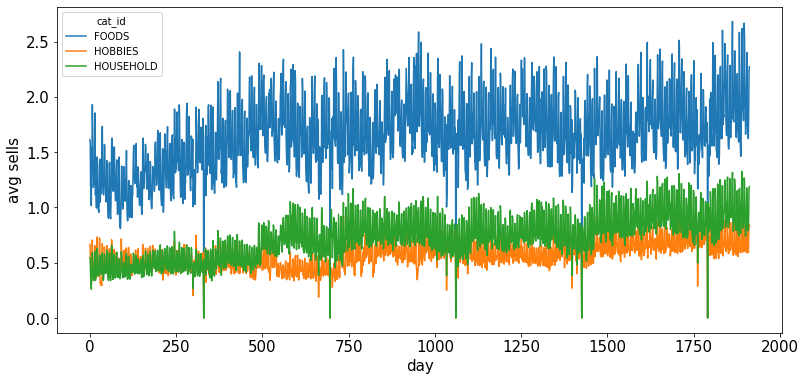

In [24]:
# read some data temporarily for EDA
sales_train_val = pd.read_csv(path_data + 'sales_train_validation.csv')
mean_per_cat = sales_train_val.groupby('cat_id').agg('mean').T.reset_index().drop('index', axis=1)
ax = mean_per_cat.plot(figsize=(13, 6))
ax.set_xlabel("day", fontsize=15)
ax.set_ylabel("avg sells", fontsize=15)
ax.tick_params(labelsize=15)
del sales_train_val

-> cyclic variations

-> overall trend for increase

-> days with sharp drop in sells

In [25]:
# merge some data temporarily for EDA
start_day = 350 #902  # 350
df_train_val_test = read_and_transform(start_day)

### Transforming into melted and merged data format... ###
Memory usage of dataframe is 1364.32 MB
Memory usage after optimization is: 638.22 MB
Decreased by 53.2%
Memory usage of dataframe is 32.57 MB
Memory usage after optimization is: 17.62 MB
Decreased by 45.9%
Memory usage of dataframe is 31.76 MB
Memory usage after optimization is: 19.40 MB
Decreased by 38.9%
Memory usage of dataframe is 3490.34 MB
Memory usage after optimization is: 2578.57 MB
Decreased by 26.1%


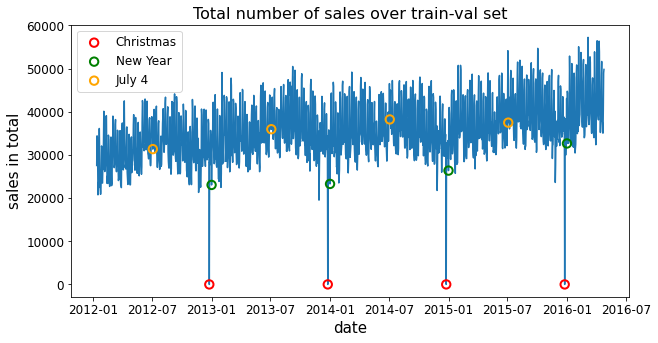

In [26]:
# total number of sells over the whole time span
sales_by_date = df_train_val_test[df_train_val_test.part=='train_val'][['date','sales']].groupby('date').sum().reset_index()
plt.figure(figsize=(10,5))
plt.plot(sales_by_date.date, sales_by_date.sales)
_ =plt.xlabel('date', fontsize=15)
_ =plt.ylabel('sales in total', fontsize=15)
_ =plt.tick_params(labelsize=12)
_ =plt.title('Total number of sales over train-val set', fontsize=16)
for year in df_train_val_test.year.unique().tolist():
    day_christmas = pd.to_datetime(str(year) + '-12-25')
    day_ny = pd.to_datetime(str(year) + '-01-01')
    day_id = pd.to_datetime(str(year) + '-07-04')
    if day_christmas<=sales_by_date.date.max():
        c = plt.scatter(pd.to_datetime(day_christmas), sales_by_date.loc[sales_by_date.date==day_christmas, 'sales'].iloc[0], s=70, linewidths= 2, edgecolor="red", facecolor='none', zorder=10)
    if (day_ny>=sales_by_date.date.min()) & (day_ny<=sales_by_date.date.max()):
        ny = plt.scatter(pd.to_datetime(day_ny), sales_by_date.loc[sales_by_date.date==day_ny, 'sales'].iloc[0], s=70, linewidths= 2, color="green", facecolor='none', zorder=10)
    if day_christmas<=sales_by_date.date.max():
        inday = plt.scatter(pd.to_datetime(day_id), sales_by_date.loc[sales_by_date.date==day_id, 'sales'].iloc[0], s=70, linewidths= 2, edgecolor="orange", facecolor='none', zorder=10)
plt.legend([c, ny, inday], ['Christmas', 'New Year', 'July 4'], fontsize=12)
#del sales_by_date

Christmas and New Year are indeed minima in number of sales, plus probably Thanksgiving. Let's check...

In [27]:
# show dates with fewest sells
df_grouped = df_train_val_test.pivot_table(index=('month','day'),values='sales',aggfunc='sum').reset_index()
df_grouped.sort_values(by=['sales'], ascending=True).head(10)

,month,day,sales
359,12,25,65.0
59,2,29,60617.0
332,11,28,102464.0
0,1,1,105351.0
331,11,27,108090.0
120,4,30,112031.0
149,5,29,113412.0
295,10,22,114292.0
302,10,29,115579.0
141,5,21,115791.0


Indeed, besides Christmas and New Year's (and 29th February, which is a leap day), Thanksgiving has fewest sells (we'll have to specify the date per year since the precise date varies)

In [28]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
df_grouped          DataFrame         month  day     sales<...>365     12   31  144360.0
df_train_val_test   DataFrame                             <...>571939 rows x 30 columns]
mean_per_cat        DataFrame    cat_id     FOODS   HOBBIE<...>\n[1913 rows x 3 columns]
sales_by_date       DataFrame               date    sales\<...>\n[1564 rows x 2 columns]
sample_submission   DataFrame                             <...>[60980 rows x 29 columns]


In [29]:
del df_grouped, df_train_val_test, mean_per_cat, sales_by_date

In [30]:
sales_train_val = pd.read_csv(path_data + 'sales_train_validation.csv')
d_cols = [col for col in sales_train_val.columns if 'd_' in col]
id_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
cols = ['id','item_id','dept_id','cat_id','store_id','state_id']
cols.extend(f"d_{day}" for day in range(800,1914))
sales_melt = sales_train_val[cols].melt(
    id_vars=id_columns, value_vars = sales_train_val[cols].drop(id_columns, axis=1).columns, 
    var_name='d', 
    value_name='sales'
)
sell_prices = pd.read_csv(path_data + 'sell_prices.csv')
calendar = pd.read_csv(path_data + 'calendar.csv')

sales_cal = sales_melt.merge(calendar[['date','wm_yr_wk','weekday','wday','month','year','d']], how='left', on=['d'])
sales_cal['date'] = pd.to_datetime(sales_cal.date, format="%Y-%m-%d %H:%M:%S")
sales_cal['day'] = sales_cal.date.dt.day

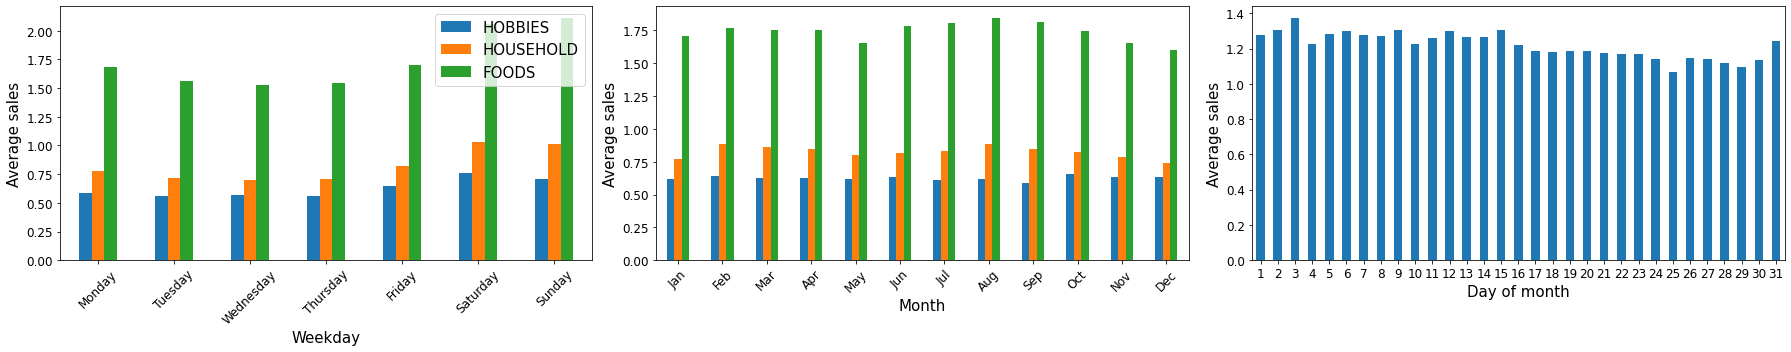

In [31]:
fig, axes = plt.subplots(1,3,figsize=(25,5))

weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
pd.concat(
    [sales_cal[sales_cal.cat_id=='HOBBIES'].groupby('weekday')['sales'].agg('mean').reindex(weekdays), 
     sales_cal[sales_cal.cat_id=='HOUSEHOLD'].groupby('weekday')['sales'].agg('mean').reindex(weekdays), 
     sales_cal[sales_cal.cat_id=='FOODS'].groupby('weekday')['sales'].agg('mean').reindex(weekdays)],
    axis=1).plot.bar(rot=45, ax=axes[0])
axes[0].set_xlabel('Weekday', fontsize=15)
axes[0].set_ylabel('Average sales', fontsize=15)
axes[0].tick_params(labelsize=12)
axes[0].legend(['HOBBIES', 'HOUSEHOLD', 'FOODS'], fontsize=15)

pd.concat(
    [sales_cal[sales_cal.cat_id=='HOBBIES'].groupby('month')['sales'].agg('mean'), 
     sales_cal[sales_cal.cat_id=='HOUSEHOLD'].groupby('month')['sales'].agg('mean'), 
     sales_cal[sales_cal.cat_id=='FOODS'].groupby('month')['sales'].agg('mean')],
    axis=1).plot.bar(rot=45, ax=axes[1])
axes[1].xaxis.set_label_text('')
axes[1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], fontsize=15)
axes[1].set_xlabel('Month', fontsize=15)
axes[1].set_ylabel('Average sales', fontsize=15)
axes[1].tick_params(labelsize=12)
axes[1].get_legend().remove()

sales_cal.groupby('day')['sales'].agg('mean').plot(kind='bar', rot=0, ax=axes[2])
axes[2].xaxis.set_label_text('')
axes[2].set_xlabel('Day of month', fontsize=15)
axes[2].set_ylabel('Average sales', fontsize=15)
axes[2].tick_params(labelsize=12)

plt.tight_layout()

-> more sales on weekends, especially for food

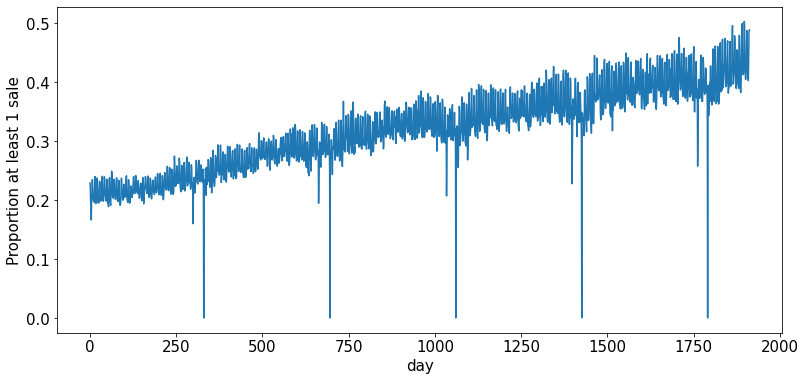

In [32]:
prop_nonzero = sales_train_val[d_cols].astype(bool).sum(axis=0).reset_index().drop('index', axis=1)/sales_train_val.shape[0]
ax = prop_nonzero.plot(figsize=(13, 6))
ax.set_xlabel("day", fontsize=15)
ax.set_ylabel("Proportion at least 1 sale", fontsize=15)
ax.tick_params(labelsize=15)
ax.get_legend().remove()

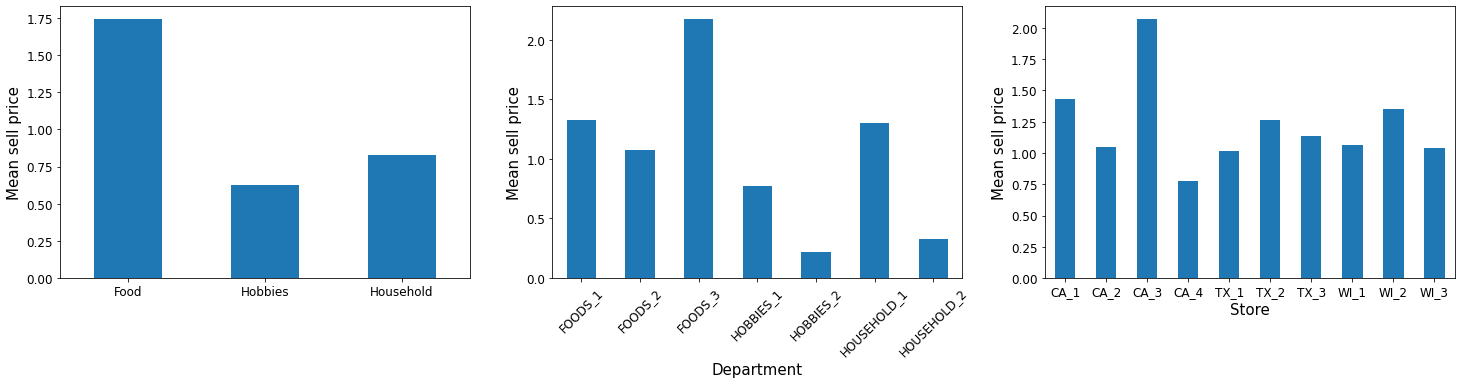

In [33]:
fig, axes = plt.subplots(1,3,figsize=(25,5))

sales_melt.groupby(['cat_id']).agg({'sales': 'mean'}).plot(kind='bar', rot=0, ax=axes[0])
axes[0].xaxis.set_label_text('')
axes[0].set_xticklabels(['Food','Hobbies','Household'], fontsize=15)
axes[0].set_ylabel('Mean sell price', fontsize=15)
axes[0].tick_params(labelsize=12)
axes[0].get_legend().remove()

sales_melt.groupby(['dept_id']).agg({'sales': 'mean'}).plot(kind='bar', rot=45, ax=axes[1])
axes[1].xaxis.set_label_text('')
axes[1].set_xlabel('Department', fontsize=15)
axes[1].set_ylabel('Mean sell price', fontsize=15)
axes[1].tick_params(labelsize=12)
axes[1].get_legend().remove()

sales_melt.groupby(['store_id']).agg({'sales': 'mean'}).plot(kind='bar', rot=45, ax=axes[2])
axes[2].xaxis.set_label_text('')
axes[2].set_xlabel('Store', fontsize=15)
axes[2].set_ylabel('Mean sell price', fontsize=15)
axes[2].tick_params(labelsize=12,rotation=0)
axes[2].get_legend().remove()

### Sell prices

In [34]:
#sell_prices.wm_yr_wk-=sell_prices.wm_yr_wk.min()

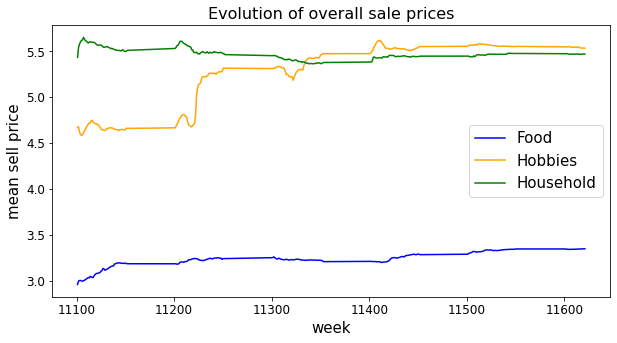

In [35]:
plt.figure(figsize=(10,5))
food, = plt.plot(sell_prices[sell_prices['item_id'].str.match('FOOD')].groupby('wm_yr_wk')['sell_price'].mean(), color='blue')
hobbies, = plt.plot(sell_prices[sell_prices['item_id'].str.match('HOBBIES')].groupby('wm_yr_wk')['sell_price'].mean(), color='orange')
household, = plt.plot(sell_prices[sell_prices['item_id'].str.match('HOUSEHOLD')].groupby('wm_yr_wk')['sell_price'].mean(), color='green')
_ =plt.xlabel('week', fontsize=15)
_ =plt.ylabel('mean sell price', fontsize=15)
_ =plt.tick_params(labelsize=12)
_ =plt.title('Evolution of overall sale prices', fontsize=16)
plt.legend([food, hobbies, household], ['Food', 'Hobbies', 'Household'], fontsize=15)
plt.show()

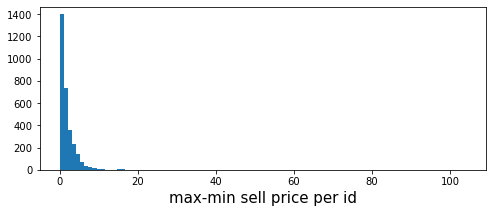

In [36]:
price_range_per_id = sell_prices.groupby('item_id')['sell_price'].agg(np.ptp)
plt.figure(figsize=(8,3))
_ = plt.hist(price_range_per_id, bins=100)
_ =plt.xlabel('max-min sell price per id', fontsize=15)

-> for individual items, variations in sell prices are quite small

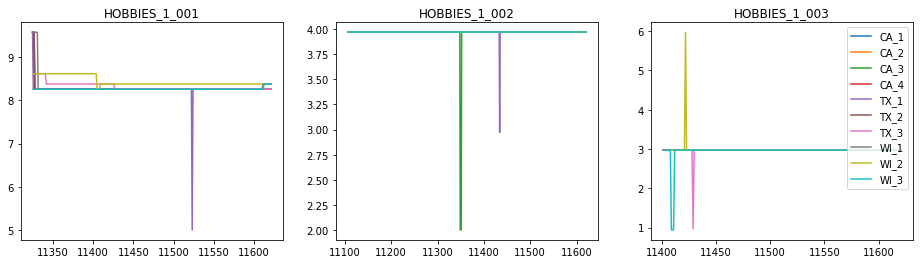

In [37]:
fig = plt.figure(figsize=(16,4))
for i, item in enumerate(['HOBBIES_1_001','HOBBIES_1_002','HOBBIES_1_003']):
    ax = fig.add_subplot(1,3,i+1)
    for store in sell_prices['store_id'].unique():
        prices_item_store = sell_prices[(sell_prices.item_id==item) & (sell_prices.store_id==store)]
        ax.plot(prices_item_store.wm_yr_wk, prices_item_store.sell_price, label=store)
    if i==2:
        ax.legend()
    ax.set_title(item, fontsize=12)

-> item prices are mostly constant with only exceptional outliers (maybe special offers?)

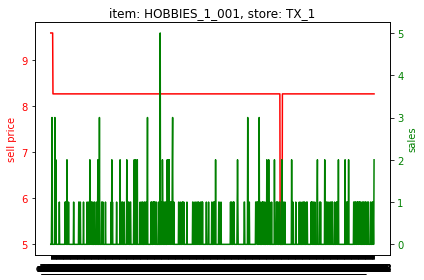

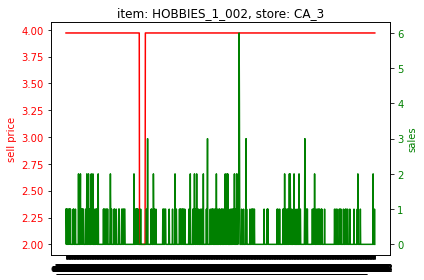

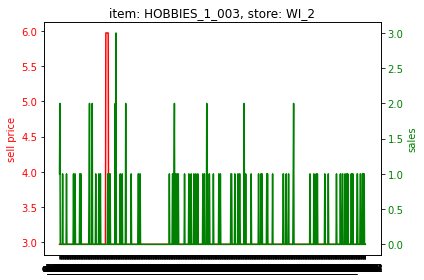

In [38]:
# investigate relationship between price and number of sales

items = ['HOBBIES_1_001','HOBBIES_1_002','HOBBIES_1_003']
stores = ['TX_1','CA_3','WI_2']

for i in range(3):
    item=items[i]
    store=stores[i]
    
    sales_item_store = sales_melt[(sales_melt.item_id==item) & (sales_melt.store_id==store)]
    sales_item_store = sales_item_store.merge(calendar[['date','wm_yr_wk','weekday','wday','month','year','d']], how='left', on=['d'])
    sales_item_store = sales_item_store.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'])
    
    fig, ax1 = plt.subplots()
    ax1.plot(sales_item_store.d, sales_item_store.sell_price, color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.set_ylabel('sell price', color='red')

    ax2 = ax1.twinx()
    ax2.plot(sales_item_store.d, sales_item_store.sales, color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylabel('sales', color='green')
    plt.title('item: ' + item + ', store: ' + store)

    fig.tight_layout()

-> there seems to be no obvious relationship between sell price and sales

In [39]:
# remove temporary variables from workspace again
del prop_nonzero, sales_cal, sales_melt, sales_train_val, sell_prices, price_range_per_id, sales_item_store, prices_item_store

In [40]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
calendar            DataFrame                date  wm_yr_w<...>n[1969 rows x 14 columns]
sample_submission   DataFrame                             <...>[60980 rows x 29 columns]


## Feature-engineering

Possible features to implement:
* lag by one week, one month, one year
* rolling mean last month, last week
* these two combined, i.e. mean for N last days
* price trend (current price vs. mean of ...)
* sell trend (#sells in last X days compared to previous X days)
* in the days before a holidays, there are probably a lot of sells, one could add a feature like 'days from holiday' or 'preceding holiday'
* encode sudden changes in price (see EDA)

In [41]:
def add_features(data):
    
    # rolling sales features
    data['lag_t7'] = data.groupby(['id'])['sales'].transform(lambda x: x.shift(7)).astype('float16')   # added 28/04
    data['lag_t28'] = data.groupby(['id'])['sales'].transform(lambda x: x.shift(28)).astype('float16')
    data['lag_t29'] = data.groupby(['id'])['sales'].transform(lambda x: x.shift(29)).astype('float16')
    data['lag_t30'] = data.groupby(['id'])['sales'].transform(lambda x: x.shift(30)).astype('float16')
    data['lag_t7_rolling_mean_t7'] = data.groupby(['id'])['sales'].transform(lambda x: x.shift(7).rolling(7).mean()).astype('float16') # added 28/04
    data['lag_t7_rolling_mean_t28'] = data.groupby(['id'])['sales'].transform(lambda x: x.shift(7).rolling(28).mean()).astype('float16') # added 28/04
    data['lag_t28_rolling_mean_t7'] = data.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(7).mean()).astype('float16')
    data['lag_t28_rolling_std_t7'] = data.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(7).std()).astype('float16')
    data['lag_t28_rolling_mean_t30'] = data.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(30).mean()).astype('float16')
    data['lag_t28_rolling_mean_t90'] = data.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(90).mean()).astype('float16')
    #data['lag_t28_rolling_mean_t180'] = data.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(180).mean()).astype('float16')
    data['lag_t28_rolling_std_t30'] = data.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(30).std()).astype('float16')
    data['lag_t28_rolling_skew_t30'] = data.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(30).skew()).astype('float16')
    data['lag_t28_rolling_kurt_t30'] = data.groupby(['id'])['sales'].transform(lambda x: x.shift(28).rolling(30).kurt()).astype('float16')
    
    # price features
    data['lag_price_t1'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1)).astype('float16')
    data['lag_price_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(7)).astype('float16')
    data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1']).astype('float16')
    data['price_change_t7'] = (data['lag_price_t7'] - data['sell_price']) / (data['lag_price_t7']).astype('float16')
    #data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max()).astype('float16')
    #data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365']).astype('float16')
    data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std()).astype('float16')
    data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std()).astype('float16')
    #data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)
    
    data['sell_price'] = data.sell_price.astype('float16')
    
    # add holidays
    holidays = [str(year) + '-12-25' for year in range (2011, 2016)] + [str(year) + '-01-01' for year in range (2011, 2017)]
    holidays = holidays + ['2011-11-24', '2012-11-22', '2013-11-28', '2014-11-27', '2015-11-26']
    holidays = pd.to_datetime(holidays)

    data['is_holiday'] = 0
    data.loc[data.date.isin(holidays),'is_holiday']=1
    data['is_holiday'] = data['is_holiday'].astype('int8')

    return data

In [42]:
def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")
            
    return dt

## Train model by department

In [57]:
# choose first day of the validation set (here using the last 28 days for validation)
first_day_val = '2016-03-27'
dep_ids = ['HOBBIES_1','HOBBIES_2','HOUSEHOLD_1','HOUSEHOLD_2','FOODS_1','FOODS_2','FOODS_3']
drop_features = ['d', 'date', 'id', 'part', 'sales', 'wm_yr_wk']

def my_split_train_val_test(df, first_day_val):
    
    # going to evaluate with the last 28 days
    x_train = df[df['date'] < first_day_val]
    y_train = x_train['sales']
    x_val = df[(df['date'] >= first_day_val) & (df['date'] <= '2016-04-24')]
    y_val = x_val['sales']
    x_train.drop(drop_features, axis=1, inplace=True)
    x_val.drop(drop_features, axis=1, inplace=True)
    #test = df[df.part=='public_leaderboard']
    '''
    x_train, x_val, y_train, y_val = train_test_split(df[df.part=='train_val'].drop(drop_features, axis=1), df[df.part=='train_val'].sales, test_size=0.1, shuffle=True, random_state=54)
    test = df_dep[df_dep.part=='public_leaderboard']
    '''
    #return x_train, y_train, x_val, y_val, test
    return x_train, y_train, x_val, y_val

To do:
* parameter tuning by department
* model stacking

### Parameter tuning

In [53]:
'''
for dep_id in dep_ids:
    
    df_dep = read_and_transform(start_day=1200, dep_id=dep_id)
    df_dep = add_features(df_dep)
    x_train, y_train, x_val, y_val, test = my_split_train_val_test(df_dep, first_day_val)

    # Define searched space
    hyper_space_lgbm = {'boosting_type': 'gbdt',
                        'metric': 'rmse',
                        'objective': 'poisson',
                        "learning_rate" : hp.choice("learning_rate", [0.075, 0.2]),
                        "sub_row" : hp.choice("sub_row", [0.75, 1]),
                        "bagging_freq" : hp.choice("bagging_freq", [0, 1]),
                        "lambda" : 0.1,
                        "num_leaves": hp.choice("num_leaves", [50, 128]),
                        "min_data_in_leaf": hp.choice("min_data_in_leaf", [20, 100]),
                        "colsample_bytree": hp.choice("colsample_bytree", [0.7, 1]),
                        "force_row_wise": hp.choice("force_row_wise", [True, False])}


    def evaluate_metric(params):

        model_lgbm = lgbm.train(params, lgtrain, 600, 
                              valid_sets=[lgtrain, lgval], early_stopping_rounds=100, 
                              verbose_eval=300)

        pred = model_lgbm.predict(x_val, num_iteration=1000)

        score = rmse(pred, y_val)

        print(score, params)

        return {
            'loss': score,
            'status': STATUS_OK,
            'stats_running': STATUS_RUNNING
        }

    def rmse(y_pred, y):
        return np.sqrt(np.mean(np.square(y - y_pred)))

    print('\n######## Searching parameters for department ' + str(dep_id) + '... ########')

    # Trail
    trials = Trials()

    # Set algorithm parameters
    algo = partial(tpe.suggest, 
                   n_startup_jobs=-1)

    # Seting the number of Evals
    MAX_EVALS= 30

    # Fit Tree Parzen Estimator
    best_vals = fmin(evaluate_metric, space=hyper_space_lgbm, verbose=1,
                     algo=algo, max_evals=MAX_EVALS, trials=trials)

    # Print best parameters
    best_params_lgbm = space_eval(hyper_space_lgbm, best_vals)

    print('BEST PARAMETERS FOR DEPARTMENT ' + str(dep_id) + ': ' + str(best_params_lgbm))
    
'''

'\nfor dep_id in dep_ids:\n    \n    df_dep = read_and_transform(start_day=1200, dep_id=dep_id)\n    df_dep = add_features(df_dep)\n    x_train, y_train, x_val, y_val, test = my_split_train_val_test(df_dep, first_day_val)\n\n    # Define searched space\n    hyper_space_lgbm = {\'boosting_type\': \'gbdt\',\n                        \'metric\': \'rmse\',\n                        \'objective\': \'poisson\',\n                        "learning_rate" : hp.choice("learning_rate", [0.075, 0.2]),\n                        "sub_row" : hp.choice("sub_row", [0.75, 1]),\n                        "bagging_freq" : hp.choice("bagging_freq", [0, 1]),\n                        "lambda" : 0.1,\n                        "num_leaves": hp.choice("num_leaves", [50, 128]),\n                        "min_data_in_leaf": hp.choice("min_data_in_leaf", [20, 100]),\n                        "colsample_bytree": hp.choice("colsample_bytree", [0.7, 1]),\n                        "force_row_wise": hp.choice("force_row_wise", [

In [54]:
# Results
'''
BEST PARAMETERS FOR DEPARTMENT HOBBIES_1: {'bagging_freq': 0, 'boosting_type': 'gbdt', 'colsample_bytree': 1, 'force_row_wise': False, 'lambda': 0.1, 'learning_rate': 0.075, 'metric': 'rmse', 'min_data_in_leaf': 100, 'num_leaves': 50, 'objective': 'poisson', 'sub_row': 0.75}
BEST PARAMETERS FOR DEPARTMENT HOBBIES_2: {'bagging_freq': 0, 'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_row_wise': True, 'lambda': 0.1, 'learning_rate': 0.075, 'metric': 'rmse', 'min_data_in_leaf': 20, 'num_leaves': 128, 'objective': 'poisson', 'sub_row': 0.75}
BEST PARAMETERS FOR DEPARTMENT HOUSEHOLD_1: {'bagging_freq': 0, 'boosting_type': 'gbdt', 'colsample_bytree': 1, 'force_row_wise': False, 'lambda': 0.1, 'learning_rate': 0.075, 'metric': 'rmse', 'min_data_in_leaf': 100, 'num_leaves': 50, 'objective': 'poisson', 'sub_row': 1}
BEST PARAMETERS FOR DEPARTMENT HOUSEHOLD_2: {'bagging_freq': 0, 'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_row_wise': False, 'lambda': 0.1, 'learning_rate': 0.075, 'metric': 'rmse', 'min_data_in_leaf': 100, 'num_leaves': 128, 'objective': 'poisson', 'sub_row': 1}
BEST PARAMETERS FOR DEPARTMENT FOODS_1: {'bagging_freq': 0, 'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_row_wise': False, 'lambda': 0.1, 'learning_rate': 0.075, 'metric': 'rmse', 'min_data_in_leaf': 20, 'num_leaves': 50, 'objective': 'poisson', 'sub_row': 1}
BEST PARAMETERS FOR DEPARTMENT FOODS_2: {'bagging_freq': 0, 'boosting_type': 'gbdt', 'colsample_bytree': 1, 'force_row_wise': False, 'lambda': 0.1, 'learning_rate': 0.2, 'metric': 'rmse', 'min_data_in_leaf': 100, 'num_leaves': 50, 'objective': 'poisson', 'sub_row': 1}
BEST PARAMETERS FOR DEPARTMENT FOODS_3: {'bagging_freq': 0, 'boosting_type': 'gbdt', 'colsample_bytree': 1, 'force_row_wise': False, 'lambda': 0.1, 'learning_rate': 0.075, 'metric': 'rmse', 'min_data_in_leaf': 20, 'num_leaves': 50, 'objective': 'poisson', 'sub_row': 0.75}
'''

"\nBEST PARAMETERS FOR DEPARTMENT HOBBIES_1: {'bagging_freq': 0, 'boosting_type': 'gbdt', 'colsample_bytree': 1, 'force_row_wise': False, 'lambda': 0.1, 'learning_rate': 0.075, 'metric': 'rmse', 'min_data_in_leaf': 100, 'num_leaves': 50, 'objective': 'poisson', 'sub_row': 0.75}\nBEST PARAMETERS FOR DEPARTMENT HOBBIES_2: {'bagging_freq': 0, 'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_row_wise': True, 'lambda': 0.1, 'learning_rate': 0.075, 'metric': 'rmse', 'min_data_in_leaf': 20, 'num_leaves': 128, 'objective': 'poisson', 'sub_row': 0.75}\nBEST PARAMETERS FOR DEPARTMENT HOUSEHOLD_1: {'bagging_freq': 0, 'boosting_type': 'gbdt', 'colsample_bytree': 1, 'force_row_wise': False, 'lambda': 0.1, 'learning_rate': 0.075, 'metric': 'rmse', 'min_data_in_leaf': 100, 'num_leaves': 50, 'objective': 'poisson', 'sub_row': 1}\nBEST PARAMETERS FOR DEPARTMENT HOUSEHOLD_2: {'bagging_freq': 0, 'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_row_wise': False, 'lambda': 0.1, 'learning_ra

### Training begins

#### LGBM


######## Training department HOBBIES_1... ########
### Transforming into melted and merged data format... ###
Memory usage of dataframe is 84.98 MB
Memory usage after optimization is: 39.87 MB
Decreased by 53.1%
Memory usage of dataframe is 32.57 MB
Memory usage after optimization is: 17.62 MB
Decreased by 45.9%
Memory usage of dataframe is 56.18 MB
Memory usage after optimization is: 30.80 MB
Decreased by 45.2%
Memory usage of dataframe is 315.17 MB
Memory usage after optimization is: 230.76 MB
Decreased by 26.8%
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.251163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4209
[LightGBM] [Info] Number of data points in the train set: 2822896, number of used features: 41
[LightGBM] [Info] Start training from score -0.239777
Training until validation scores don't improve for 50 rounds
[100]	

Memory usage of dataframe is 163.65 MB
Memory usage after optimization is: 119.82 MB
Decreased by 26.8%
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4233
[LightGBM] [Info] Number of data points in the train set: 1465728, number of used features: 41
[LightGBM] [Info] Start training from score 0.292779
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2.05343	valid_1's rmse: 1.90771
Early stopping, best iteration is:
[92]	training's rmse: 2.05661	valid_1's rmse: 1.90691
Our val rmse score is 1.9069097088326041
Predicting day 1 of 28
Predicting day 2 of 28
Predicting day 3 of 28
Predicting day 4 of 28
Predicting day 5 of 28
Predicting day 6 of 28
Predicting day 7 of 28
Predicting day 8 of 28
Predicting day 9 of 28
Predicting day 10 of 28
Predicti

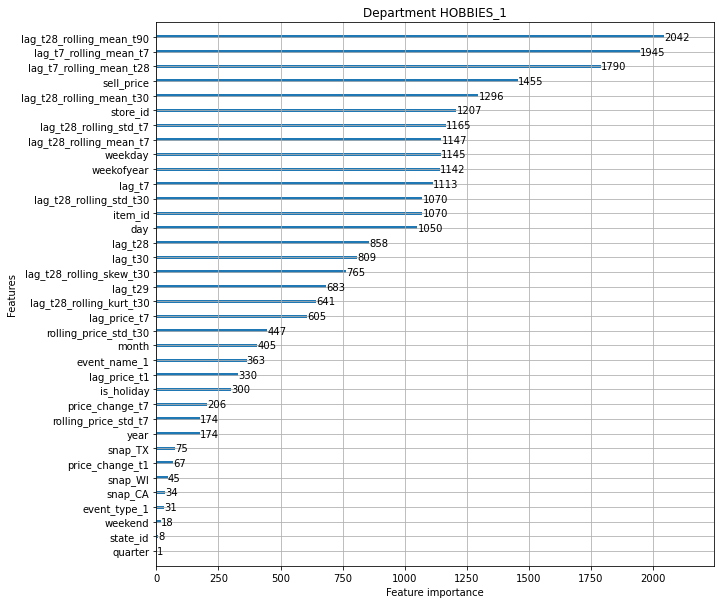

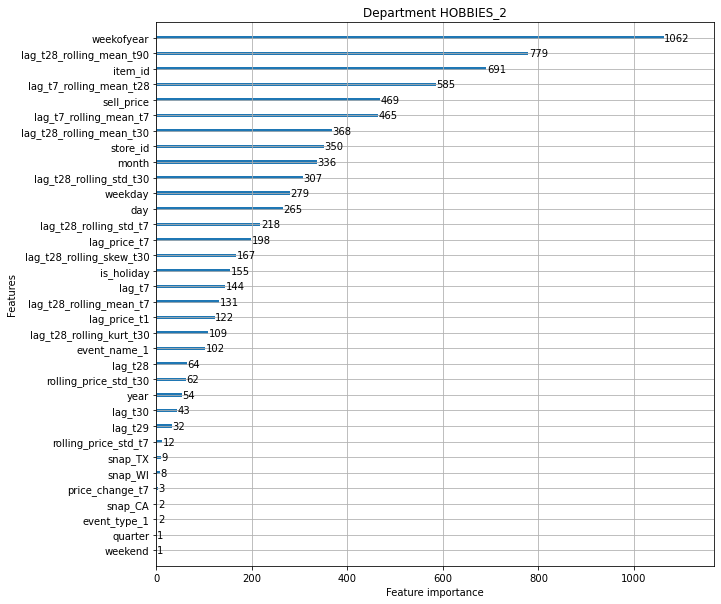

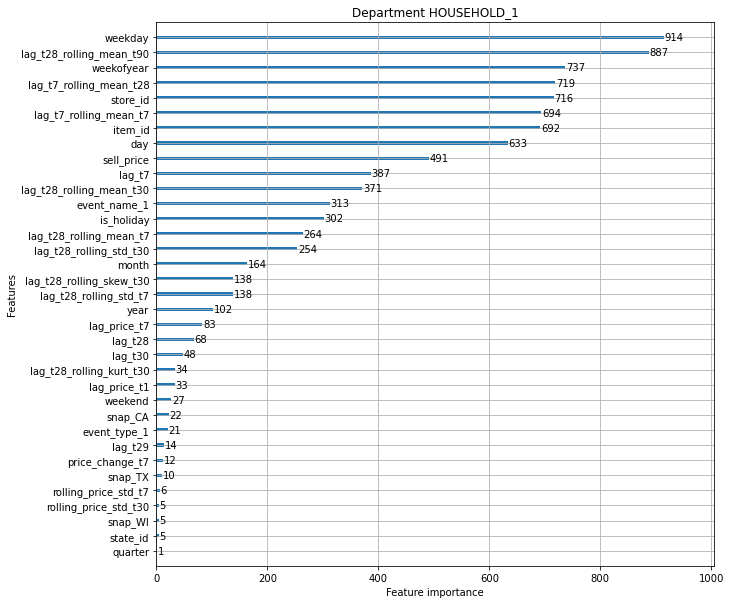

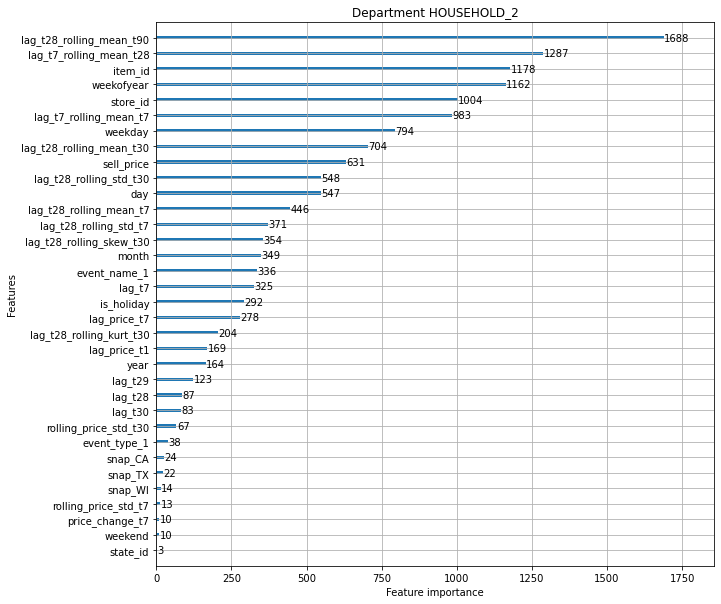

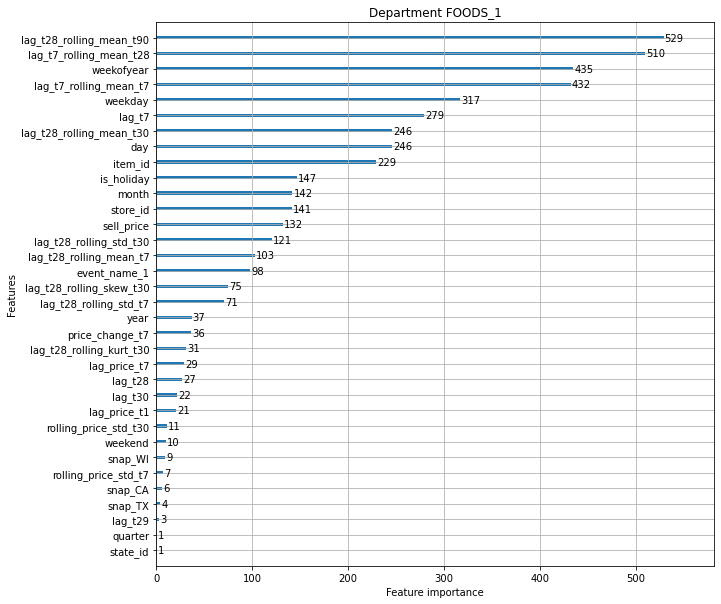

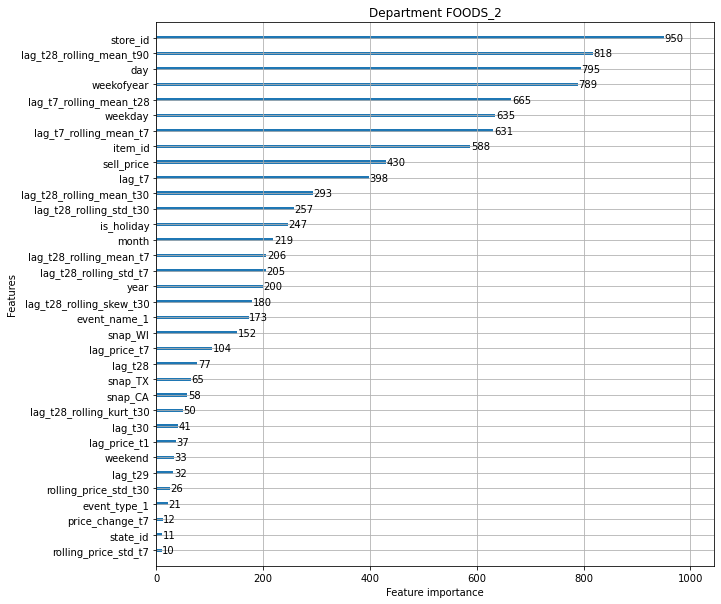

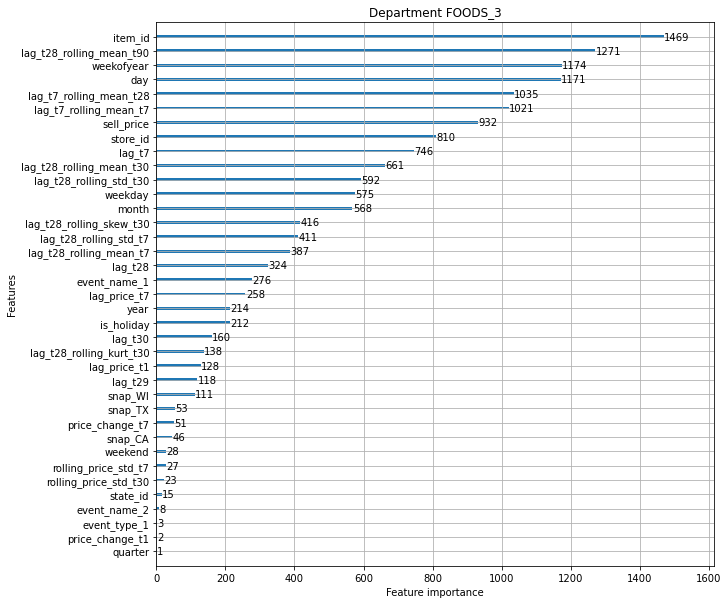

In [59]:
test_all_dep = pd.DataFrame()

start_day=1200

for dep_id in dep_ids:
    
    print('\n######## Training department ' + str(dep_id) + '... ########')
    
    df_dep = read_and_transform(start_day, dep_id=dep_id)
    # note test dates to predict later
    test_dates = df_dep[df_dep.part=='public_leaderboard'].date.unique()
    
    df_dep_trainval = df_dep[df_dep.part=='train_val']
    df_dep_trainval = add_features(df_dep_trainval)
    
    x_train, y_train, x_val, y_val = my_split_train_val_test(df_dep_trainval, first_day_val)

    #del df_dep
    #gc.collect()
    
    # train model
    params = {'bagging_freq': 0,
              'boosting_type': 'gbdt',
              'colsample_bytree': 1,
              'force_row_wise': False,
              'lambda': 0.1,
              'learning_rate': 0.075,
              'metric': 'rmse',
              'min_data_in_leaf': 100,
              'num_leaves': 50,
              'objective': 'poisson',
              'sub_row': 1}
    
    train_set = lgbm.Dataset(x_train, y_train)
    del x_train, y_train
    val_set = lgbm.Dataset(x_val, y_val)

    model = lgbm.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50, valid_sets = [train_set, val_set], verbose_eval = 100)
    
    # Plot feature importance
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    lgbm.plot_importance(model, ax=ax)
    ax.set_title('Department ' + dep_id, fontsize=12)
    
    
    # predict validation
    val_pred = model.predict(x_val)
    val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
    print(f'Our val rmse score is {val_score}')
    
    # predict test set on day-by-day basis
    for i, date in enumerate(test_dates):
        
        print('Predicting day ' + str(i+1) + ' of ' + str(len(test_dates)))
        
        df_day = df_dep[(df_dep.date<=date) & (df_dep.date >= date-pd.Timedelta(days=120))] # make sure to include enough history to be able to compute lag features
        df_day = add_features(df_day)
        df_day=df_day[df_day.date==date]
        df_dep.loc[df_dep.date==date, 'sales'] = model.predict(df_day.drop(drop_features, axis=1))
    
    df_dep_test = df_dep[df_dep.part=='public_leaderboard']
    test_all_dep = test_all_dep.append(df_dep_test)
    
    del df_dep, df_dep_test, df_day, x_val, y_val
    gc.collect()
    
    '''
    # predict test
    y_test_pred = model.predict(test.drop(drop_features, axis=1))
    test['sales'] = y_test_pred
    test_all_dep = test_all_dep.append(test)
    del test, x_val, y_val
    '''

In [60]:
sample_submission = pd.read_csv(path_data + 'sample_submission.csv')
predictions = test_all_dep[['id', 'date', 'sales']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'sales').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in sample_submission['id'] if 'evaluation' in row] 
evaluation = sample_submission[sample_submission['id'].isin(evaluation_rows)]

validation = sample_submission[['id']].merge(predictions, on = 'id')
final_lgbm = pd.concat([validation, evaluation])
final_lgbm.to_csv('submission.csv', index = False)
del predictions, evaluation, validation, sample_submission

In [61]:
final_lgbm

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.847971,0.747473,0.776209,0.855743,0.873176,1.157900,1.175988,0.890912,0.904957,0.861147,0.872418,0.913052,1.203447,1.134683,0.898823,0.814870,0.808596,0.848801,0.953549,1.203860,1.151890,0.889849,0.823162,0.824715,0.838130,0.906875,1.177978,1.154873
1,HOBBIES_1_002_CA_1_validation,0.182628,0.172927,0.191910,0.180454,0.202002,0.239471,0.226390,0.172784,0.164844,0.172806,0.171904,0.200585,0.237065,0.224687,0.164536,0.160225,0.160898,0.161586,0.196587,0.249906,0.243770,0.172351,0.165823,0.168552,0.167972,0.202686,0.238500,0.236312
2,HOBBIES_1_003_CA_1_validation,0.506562,0.527599,0.542043,0.461820,0.545863,0.726910,0.689803,0.502578,0.473758,0.467788,0.441409,0.569316,0.703313,0.669273,0.508051,0.482333,0.481582,0.495819,0.595922,0.734866,0.769155,0.571052,0.555284,0.553319,0.517288,0.584218,0.747405,0.701635
3,HOBBIES_1_004_CA_1_validation,1.810874,1.610948,1.488271,1.512859,1.867448,2.419377,2.279977,1.917905,1.830921,1.761537,1.718459,2.058931,2.615560,2.319684,1.894173,1.696212,1.728879,1.730956,2.089746,2.556556,2.531657,1.878346,1.745282,1.732975,1.747352,2.106935,2.683243,2.473535
4,HOBBIES_1_005_CA_1_validation,0.931723,0.906809,0.911652,0.924593,1.100131,1.426871,1.535119,1.220847,1.201970,1.082768,1.038484,1.183324,1.450799,1.384836,1.074364,1.000759,0.988481,0.987712,1.188922,1.510695,1.441505,1.072981,1.000607,0.999648,0.999043,1.139785,1.537363,1.455596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60976,FOODS_3_824_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60977,FOODS_3_825_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60978,FOODS_3_826_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### XGBoost


######## Training department HOBBIES_1... ########
### Transforming into melted and merged data format... ###
Memory usage of dataframe is 84.98 MB
Memory usage after optimization is: 39.87 MB
Decreased by 53.1%
Memory usage of dataframe is 32.57 MB
Memory usage after optimization is: 17.62 MB
Decreased by 45.9%
Memory usage of dataframe is 56.18 MB
Memory usage after optimization is: 30.80 MB
Decreased by 45.2%
Memory usage of dataframe is 315.17 MB
Memory usage after optimization is: 230.76 MB
Decreased by 26.8%
[0]	validation_0-rmse:2.13444	validation_1-rmse:2.11148
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.01277	validation_1-rmse:1.98681
[2]	validation_0-rmse:1.94709	validation_1-rmse:1.92293
[3]	validation_0-rmse:1.91103	validation_1-rmse:1.88907
[4]	validation_0-rmse:1.89323	validation_1-rmse:1.87335
[5]	validation_0-rmse:1.88208	validation

Predicting day 8 of 28
Predicting day 9 of 28
Predicting day 10 of 28
Predicting day 11 of 28
Predicting day 12 of 28
Predicting day 13 of 28
Predicting day 14 of 28
Predicting day 15 of 28
Predicting day 16 of 28
Predicting day 17 of 28
Predicting day 18 of 28
Predicting day 19 of 28
Predicting day 20 of 28
Predicting day 21 of 28
Predicting day 22 of 28
Predicting day 23 of 28
Predicting day 24 of 28
Predicting day 25 of 28
Predicting day 26 of 28
Predicting day 27 of 28
Predicting day 28 of 28

######## Training department HOUSEHOLD_2... ########
### Transforming into melted and merged data format... ###
Memory usage of dataframe is 105.20 MB
Memory usage after optimization is: 49.32 MB
Decreased by 53.1%
Memory usage of dataframe is 32.57 MB
Memory usage after optimization is: 17.62 MB
Decreased by 45.9%
Memory usage of dataframe is 56.18 MB
Memory usage after optimization is: 30.80 MB
Decreased by 45.2%
Memory usage of dataframe is 389.83 MB
Memory usage after optimization is: 285

[13]	validation_0-rmse:1.70982	validation_1-rmse:1.85215
[14]	validation_0-rmse:1.70921	validation_1-rmse:1.85124
[15]	validation_0-rmse:1.70855	validation_1-rmse:1.84797
[16]	validation_0-rmse:1.70813	validation_1-rmse:1.84828
[17]	validation_0-rmse:1.70767	validation_1-rmse:1.84656
[18]	validation_0-rmse:1.70709	validation_1-rmse:1.84495
[19]	validation_0-rmse:1.70663	validation_1-rmse:1.84588
[20]	validation_0-rmse:1.70619	validation_1-rmse:1.84496
[21]	validation_0-rmse:1.70571	validation_1-rmse:1.84476
[22]	validation_0-rmse:1.70516	validation_1-rmse:1.84485
[23]	validation_0-rmse:1.70467	validation_1-rmse:1.84674
[24]	validation_0-rmse:1.70436	validation_1-rmse:1.84579
[25]	validation_0-rmse:1.70411	validation_1-rmse:1.84311
[26]	validation_0-rmse:1.70385	validation_1-rmse:1.84285
[27]	validation_0-rmse:1.70361	validation_1-rmse:1.84452
[28]	validation_0-rmse:1.70321	validation_1-rmse:1.84342
[29]	validation_0-rmse:1.70274	validation_1-rmse:1.84178
[30]	validation_0-rmse:1.70255	

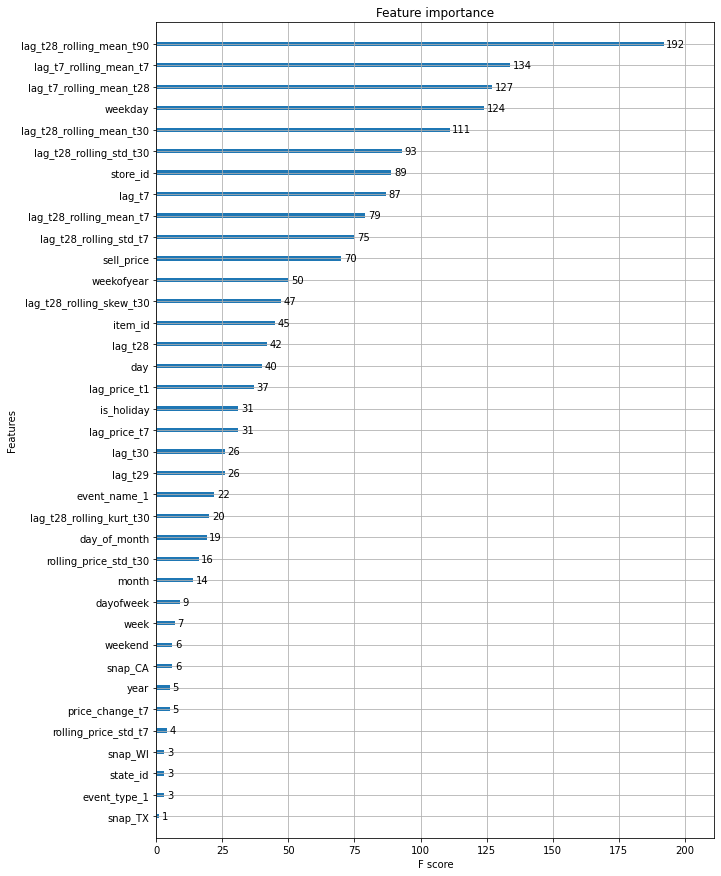

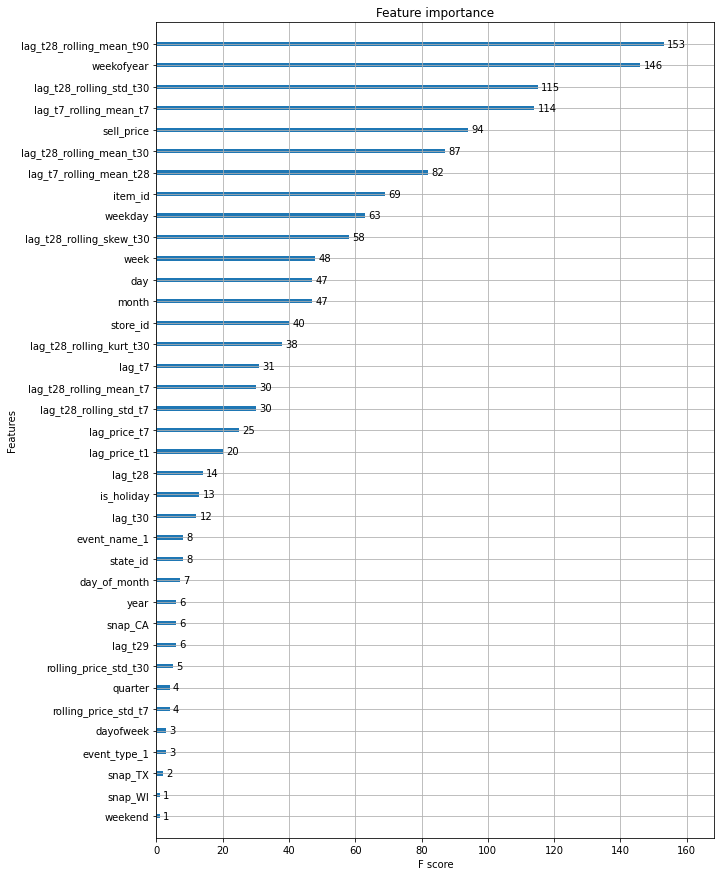

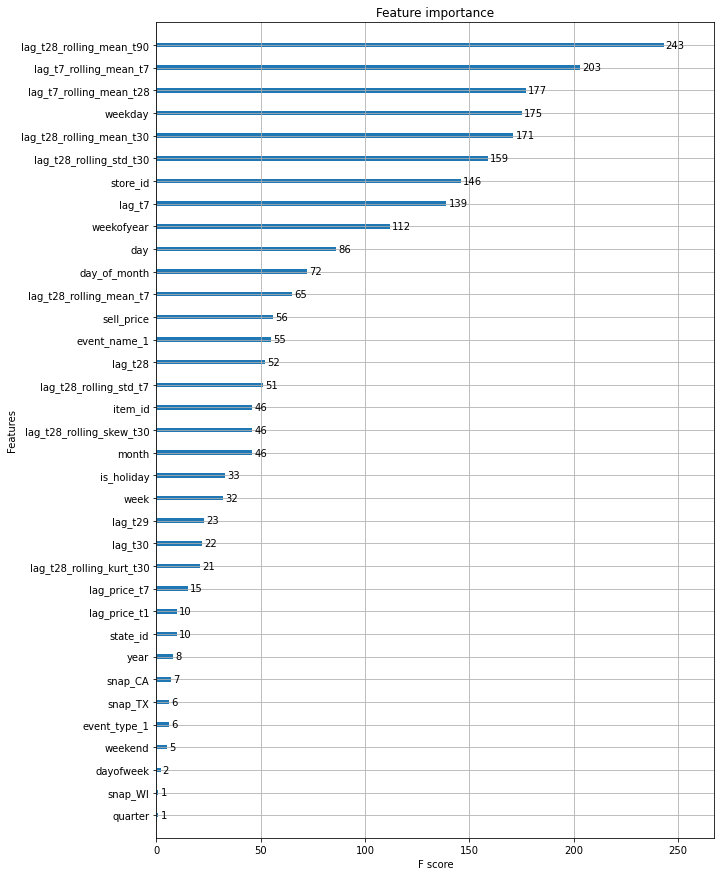

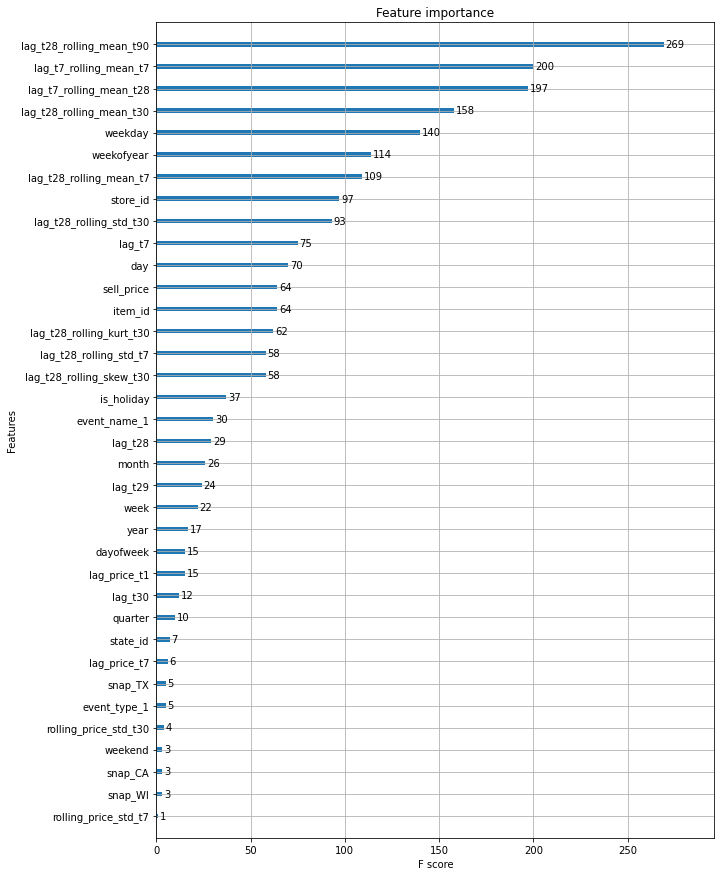

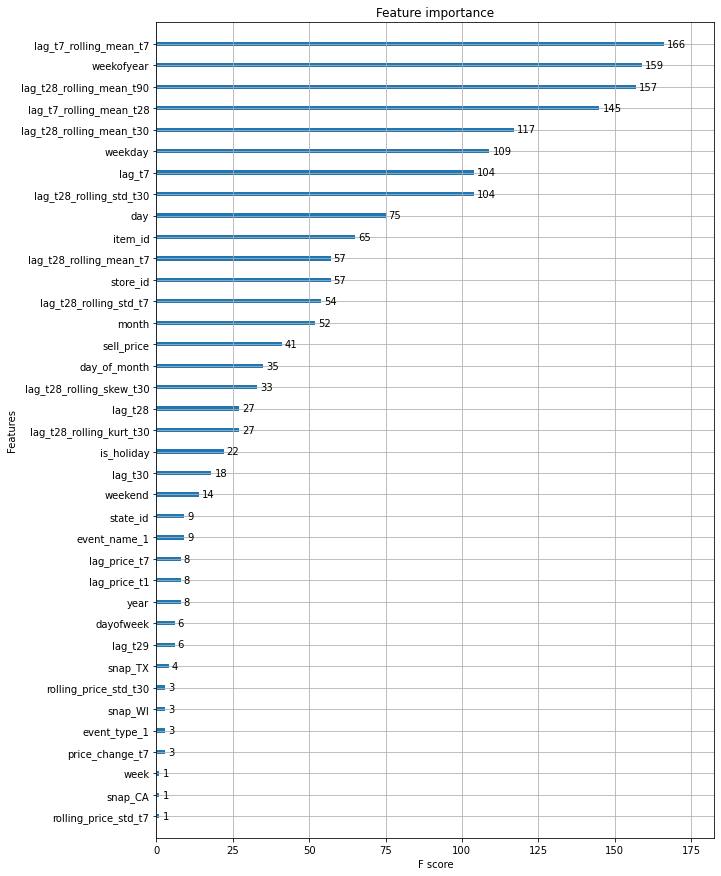

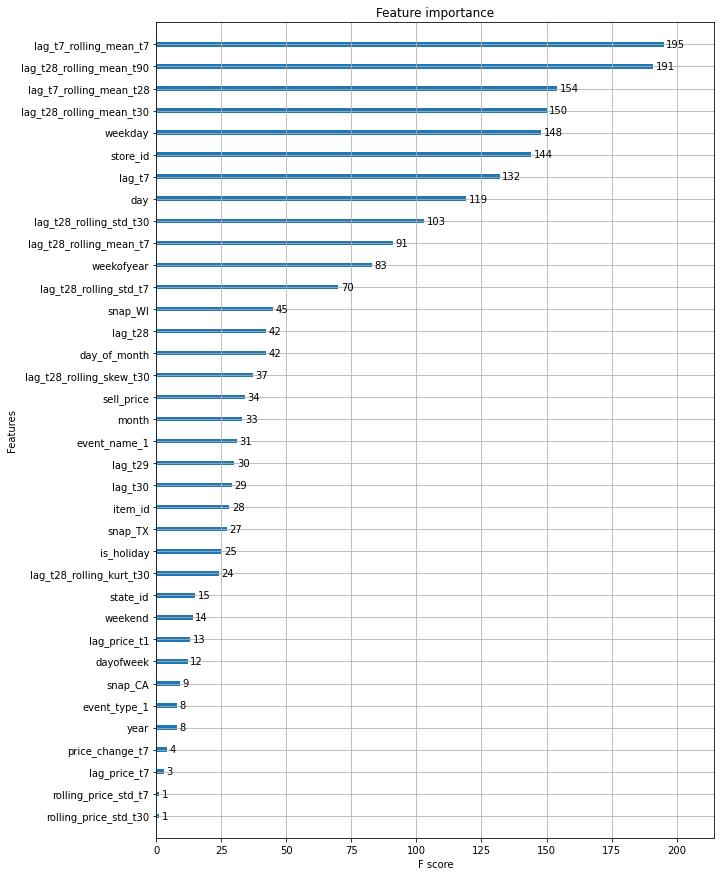

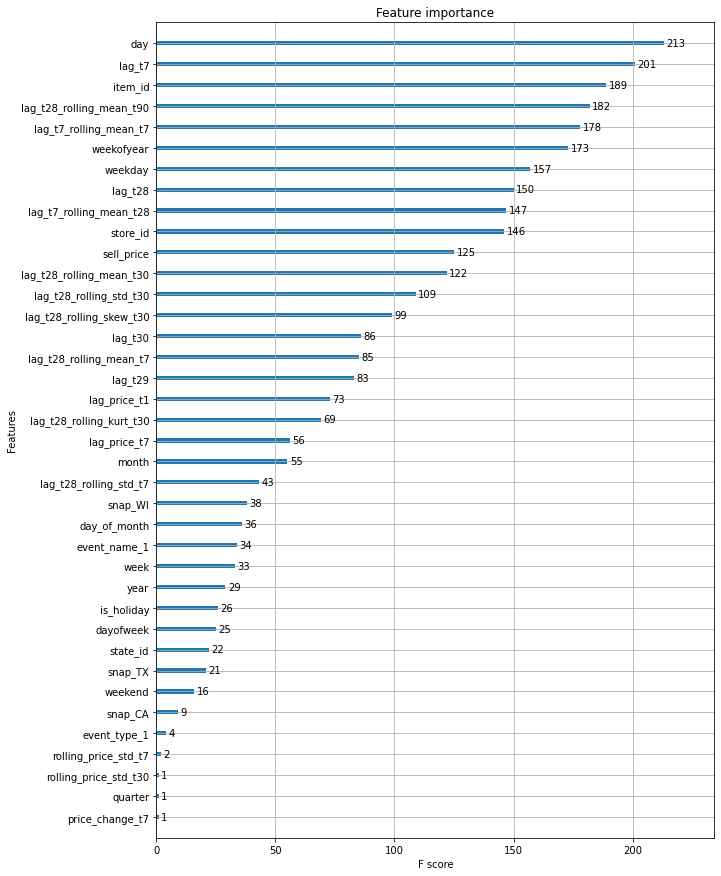

In [63]:
test_all_dep = pd.DataFrame()

for dep_id in dep_ids:
    
    print('\n######## Training department ' + str(dep_id) + '... ########')
    
    df_dep = read_and_transform(start_day, dep_id=dep_id)
    # note test dates to predict later
    test_dates = df_dep[df_dep.part=='public_leaderboard'].date.unique()
    
    df_dep_trainval = df_dep[df_dep.part=='train_val']
    df_dep_trainval = add_features(df_dep_trainval)
    
    x_train, y_train, x_val, y_val = my_split_train_val_test(df_dep_trainval, first_day_val)

    ts = time.time()
    
    model_xgb = XGBRegressor(
        max_depth=8,
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=42)

    model_xgb.fit(
        x_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(x_train, y_train), (x_val, y_val)], 
        verbose=True, 
        early_stopping_rounds = 10)

    time.time() - ts

    from xgboost import plot_importance

    fig, ax = plt.subplots(1,1,figsize=(10,15))
    plot_importance(booster=model_xgb, ax=ax)
    
    # predict validation
    val_pred = model_xgb.predict(x_val)
    val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
    print(f'Our val rmse score is {val_score}')
    
    
    #y_test_pred = model.predict(test.drop(drop_features, axis=1))
    
    # predict test set on day-by-day basis
    for i, date in enumerate(test_dates):
        
        print('Predicting day ' + str(i+1) + ' of ' + str(len(test_dates)))
        
        df_day = df_dep[(df_dep.date<=date) & (df_dep.date >= date-pd.Timedelta(days=120))] # make sure to include enough history to be able to compute lag features
        df_day = add_features(df_day)
        df_day=df_day[df_day.date==date]
        df_dep.loc[df_dep.date==date, 'sales'] = model_xgb.predict(df_day.drop(drop_features, axis=1))
    
    df_dep_test = df_dep[df_dep.part=='public_leaderboard']
    test_all_dep = test_all_dep.append(df_dep_test)
    
    del df_dep, df_dep_test, df_day, x_val, y_val
    gc.collect()

In [64]:
sample_submission = pd.read_csv(path_data + 'sample_submission.csv')
predictions = test_all_dep[['id', 'date', 'sales']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'sales').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in sample_submission['id'] if 'evaluation' in row] 
evaluation = sample_submission[sample_submission['id'].isin(evaluation_rows)]

validation = sample_submission[['id']].merge(predictions, on = 'id')
final_xgb = pd.concat([validation, evaluation])

del predictions, evaluation, validation, sample_submission

In [66]:
# select the relative weight of the models
weight_lgbm = 0.8
weight_xgb = 1-weight_lgbm
final_combined = final_lgbm.copy()
for i in range(1,29):
    final_combined['F'+str(i)] *= weight_lgbm
    final_combined['F'+str(i)] += (final_xgb['F'+str(i)]*weight_xgb)
final_combined.to_csv('submission.csv', index = False)
final_combined

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.856935,0.763382,0.786371,0.859581,0.891089,1.150457,1.154594,0.882032,0.895409,0.868234,0.873724,0.920970,1.205183,1.149107,0.912926,0.823723,0.814305,0.844445,0.956801,1.203556,1.152663,0.896405,0.833447,0.831600,0.847956,0.921996,1.176013,1.156463
1,HOBBIES_1_002_CA_1_validation,0.182227,0.174466,0.193269,0.184428,0.204962,0.238279,0.226331,0.171960,0.164533,0.169962,0.168594,0.197069,0.229484,0.219581,0.162779,0.159330,0.159869,0.160419,0.196591,0.242477,0.239607,0.169518,0.164296,0.167404,0.166940,0.204434,0.236350,0.231463
2,HOBBIES_1_003_CA_1_validation,0.514663,0.531493,0.549020,0.461030,0.536349,0.700700,0.676295,0.504046,0.482923,0.475873,0.445469,0.556548,0.676486,0.649254,0.492831,0.480810,0.483465,0.495187,0.588397,0.729102,0.756533,0.554326,0.541711,0.540139,0.513179,0.580260,0.719213,0.682598
3,HOBBIES_1_004_CA_1_validation,1.833719,1.634281,1.490795,1.517077,1.880505,2.383361,2.278938,1.891265,1.815769,1.761455,1.737883,2.084866,2.588389,2.357494,1.904908,1.730059,1.756193,1.764726,2.102258,2.541186,2.520201,1.879331,1.776187,1.746553,1.770972,2.116009,2.666995,2.475342
4,HOBBIES_1_005_CA_1_validation,0.927689,0.896638,0.904084,0.922164,1.111763,1.418441,1.560750,1.232089,1.219904,1.091588,1.037266,1.184084,1.441107,1.383369,1.065508,0.998807,0.988984,0.988369,1.189341,1.494288,1.437870,1.065598,0.990244,0.989477,0.988993,1.123707,1.494272,1.458764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60976,FOODS_3_824_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60977,FOODS_3_825_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60978,FOODS_3_826_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
'''
sample_submission = pd.read_csv(path_data + 'sample_submission.csv')
predictions = test_all_dep[['id', 'date', 'sales']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'sales').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in sample_submission['id'] if 'evaluation' in row] 
evaluation = sample_submission[sample_submission['id'].isin(evaluation_rows)]

validation = sample_submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])
# not clear yet why there are nan
#final.dropna(inplace = True)
final.to_csv('submission.csv', index = False)
'''